# Brain Tumor Segmentation

## (Un)Healthy Brain Classification

In [1]:
import os
import cv2
import urllib
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations
import time
import argparse
from tqdm import tqdm
import warnings
import sklearn as sk
import itertools

# Pytorch libraries and subsidiaries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
import torchvision as tv
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms as T
from torchsummary import summary # allows for keras-like summaries of models in pytorch
from torchvision.utils import make_grid

### Check CUDA Capability and Set Device

In [2]:
if cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on ' + cuda.get_device_name(device))
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on NVIDIA GeForce GTX 1070


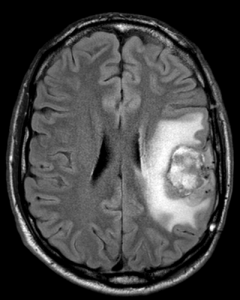

(300, 240, 3)

In [3]:
# Download an example image
path = ('brain-tumor-dataset/Brain Tumor/Cancer (1).png')

input_image = Image.open(path)

display(input_image)
cv2.imread(path).shape

### Create Pandas Dataframe of Images

In [4]:
tumor_dir = 'brain-tumor-dataset/Brain Tumor'
healthy_dir = 'brain-tumor-dataset/Healthy'
dirlist = [tumor_dir, healthy_dir]
classes = [1, 0] # 1 = tumor, 0 = no tumor
filepaths = []
labels = []
for d,c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries,Lseries], axis=1, names=['file_paths', 'labels'])
df = pd.DataFrame(np.array(df).reshape(7864,2), columns=['file_paths', 'labels'])
print(df['labels'].value_counts())

filepaths:  7864    labels:  7864
1    5277
0    2587
Name: labels, dtype: int64


### Dataset Splitting

In [5]:
train_df, test_df = train_test_split(df, train_size=0.90, random_state=0)
test_df, valid_df = train_test_split(test_df, train_size=0.5, random_state=0)

print('Training Set:')
print(train_df.labels.value_counts())
print('Validation Set:')
print(valid_df.labels.value_counts())
print('Test Set:')
print(test_df.labels.value_counts())

Training Set:
1    4753
0    2324
Name: labels, dtype: int64
Validation Set:
1    259
0    135
Name: labels, dtype: int64
Test Set:
1    265
0    128
Name: labels, dtype: int64


In [6]:
X_train = train_df.file_paths.values
y_train = train_df.labels.values
X_valid = valid_df.file_paths.values
y_valid = valid_df.labels.values
X_test = test_df.file_paths.values
y_test = test_df.labels.values

In [7]:
class BrainMRIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y
    
    transform = T.Compose([
        # T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor()])

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert('RGB')
        image = self.transform(image)
        image = np.transpose(image, (0, 2, 1))
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [8]:
train_data = BrainMRIDataset(X_train, y_train)
valid_data = BrainMRIDataset(X_valid, y_valid)
test_data = BrainMRIDataset(X_test, y_test)

trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
validloader = DataLoader(valid_data, batch_size=32, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

### ResNet Model Definition

In [35]:
def resnet_model(pretrained, requires_grad):
    resnet_model = tv.models.resnet152(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in resnet_model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in resnet_model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
    return resnet_model
    
resnet_model = resnet_model(pretrained=True, requires_grad=False).to(device) # Frozen hidden layers model 
# print(model)

In [36]:
# optimizer
optimizer = optim.SGD(resnet_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
# loss function
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [37]:
#validation function
def validate(model, valid_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_dataloader), total=int(len(valid_data)/valid_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(valid_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(valid_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [38]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [56]:
%%capture
%%script false --no-raise-error
warnings.filterwarnings('ignore')

print('CUDA Enabled: ' + str(next(resnet_model.parameters()).is_cuda))

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(50):
    print(f"Epoch {epoch + 1} of 50")
    train_epoch_loss, train_epoch_accuracy = fit(resnet_model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(resnet_model, validloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print(f"{(end-start) / 60:.3f} minutes")

In [57]:
%%capture --no-stderr
%%script false --no-raise-error
PATH = './resnet_brain.pth'
torch.save(resnet_model, PATH)

In [58]:
if torch.cuda.is_available():
    resnet_model = torch.load('./resnet_brain.pth', map_location='cuda:0')
else:
    resnet_model = torch.load('./resnet_brain.pth', map_location=torch.device('cpu'))

In [68]:
# Testing
correct = 0
total = 0
X_wrong = []
if torch.cuda.is_available():
    y_pred = torch.Tensor([]).cuda()
else:
    y_pred = torch.Tensor([])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = resnet_model(images) # feed images into resnet and get predictions
        y_pred = torch.cat((y_pred, outputs), dim=0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if(predicted != labels):
            X_wrong.append((images.cpu(), labels.cpu()))

y_pred = np.uint8(np.argmax(y_pred.cpu(), axis=1))
y_test = np.uint8(y_test)

In [86]:
print(sk.metrics.classification_report(y_test, y_pred))

Test Accuracy: 96 %
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       128
           1       0.98      0.97      0.98       265

    accuracy                           0.97       393
   macro avg       0.96      0.97      0.97       393
weighted avg       0.97      0.97      0.97       393



In [60]:
conf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)

In [61]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[123   5]
 [  7 258]]


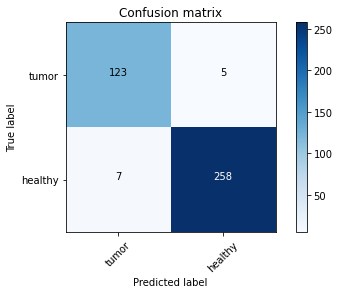

In [62]:
plot_confusion_matrix(conf_matrix, ['tumor', 'healthy'])

Total Misclassified: 12
Predicted Label: Healthy
True Label: Tumor
False Negative


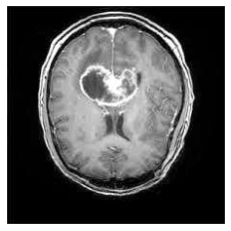

In [63]:
fig = plt.figure()
plt.axis('off')
wrong_index = 9
print('Total Misclassified: ' + str(len(X_wrong)))
if X_wrong[wrong_index][1].item() == 1:
    print('Predicted Label: Healthy\nTrue Label: Tumor\nFalse Negative')
else:
    print('Predicted Label: Tumor\nTrue Label: Healthy\nFalse Positive')
    
plt.imshow(X_wrong[wrong_index][0].permute(3, 2, 0, 1).squeeze())